In [7]:
import os
import shutil
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

# 資料增強與標準化
transform = transforms.Compose([
    transforms.Resize(256),  # 首先將圖像大小調整為 256x256
    transforms.CenterCrop(224),  # 然後將圖像中心裁剪為 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [20]:
# 加載數據
train_dataset = datasets.ImageFolder(root='train', transform=transform)
val_dataset = datasets.ImageFolder(root='val', transform=transform)
test_dataset = datasets.ImageFolder(root='test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# 定義訓練 與 驗證 function

In [21]:
from tqdm import tqdm

# 訓練函數
def train(epoch, epochs, model, train_loader, optimizer, loss_function, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    train_bar = tqdm(train_loader, file=sys.stdout)
    
    for step, data in enumerate(train_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # 確保數據在正確的設備上
        optimizer.zero_grad()
        logits = model(images)  # 模型輸出
        loss = loss_function(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 計算準確率
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, epochs, loss)
    running_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    return running_loss, accuracy

In [22]:
# 驗證函數
def validate(epoch, epochs, model, validate_loader, loss_function, device):
    model.eval()
    acc = 0.0
    val_loss = 0.0
    val_num = len(validate_loader.dataset)
    
    with torch.no_grad():
        val_bar = tqdm(validate_loader, file=sys.stdout)
        for val_data in val_bar:
            val_images, val_labels = val_data
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            outputs = model(val_images)
            loss = loss_function(outputs, val_labels)
            val_loss += loss.item() * val_images.size(0)

            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_labels).sum().item()

            val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1, epochs)
    
    val_loss /= val_num
    val_accurate = 100. *acc / val_num
    return val_loss, val_accurate

# import model

In [23]:
from dy_resnet import resnet18

# 設定設備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using {} device.".format(device))

# 設定模型為 resnet18
model = resnet18()
model = model.to(device)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

using cuda device.


# training

In [25]:
import time
import sys
import tqdm as notebook_tqdm

# 訓練和驗證模型
num_epochs = 30
best_acc = 0.0
save_path = 'best_dy_resnet18.pth'
t_l, t_a = [], []
v_l, v_a = [], []
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_accuracy = train(epoch, num_epochs, model, train_loader, optimizer, criterion, device)
    val_loss, val_accurate = validate(epoch, num_epochs, model, val_loader, criterion, device)
    t_l.append(train_loss)
    t_a.append(train_accuracy)
    v_l.append(val_loss)
    v_a.append(val_accurate)
    
    print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f' %
            (epoch + 1, train_loss, train_accuracy))
    print('[epoch %d] val_loss: %.3f  val_accuracy: %.3f' %
            (epoch + 1, val_loss, val_accurate))
    
    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(model.state_dict(), save_path)
    end_time = time.time()
    print(f'Training_Time: {end_time - start_time:.2f} seconds')
    
print('訓練完成')

valid epoch[1/30]: 100%|██████████| 15/15 [00:04<00:00,  3.50it/s]
[epoch 1] train_loss: 3.163  train_accuracy: 15.435
[epoch 1] val_loss: 3.133  val_accuracy: 19.111
Training_Time: 192.05 seconds
valid epoch[2/30]: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]
[epoch 2] train_loss: 2.496  train_accuracy: 29.619
[epoch 2] val_loss: 2.278  val_accuracy: 33.778
Training_Time: 190.83 seconds
valid epoch[3/30]: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]
[epoch 3] train_loss: 2.027  train_accuracy: 41.003
[epoch 3] val_loss: 1.995  val_accuracy: 44.222
Training_Time: 188.40 seconds
valid epoch[4/30]: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]
[epoch 4] train_loss: 1.664  train_accuracy: 50.258
[epoch 4] val_loss: 1.683  val_accuracy: 48.222
Training_Time: 189.74 seconds
valid epoch[5/30]: 100%|██████████| 15/15 [00:04<00:00,  3.60it/s]
[epoch 5] train_loss: 1.388  train_accuracy: 57.713
[epoch 5] val_loss: 1.534  val_accuracy: 54.889
Training_Time: 189.11 seconds
valid epoch[6/3

In [27]:
# 測試模型
model.load_state_dict(torch.load('best_dy_resnet18.pth'))
model.eval()
test_running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_running_corrects += torch.sum(preds == labels.data)

test_acc = test_running_corrects.double() / len(test_dataset)
print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.6467


In [28]:
def save_metrics_to_file(t_l, t_a, v_l, v_a, filename='metrics.txt'):
    with open(filename, 'w') as file:
        file.write("Train Loss:\n")
        for item in t_l:
            file.write(f"{item}\n")
        
        file.write("Train Accuracy:\n")
        for item in t_a:
            file.write(f"{item}\n")
        
        file.write("Validation Loss:\n")
        for item in v_l:
            file.write(f"{item}\n")
        
        file.write("Validation Accuracy:\n")
        for item in v_a:
            file.write(f"{item}\n")

In [29]:
# 假設 t_l, t_a, v_l, v_a 已經被填充
filename = 'dy_resnet18.txt'
save_metrics_to_file(t_l, t_a, v_l, v_a, filename)

# import original resnet18

In [34]:
import timm

# 設定設備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using {} device.".format(device))

# 設定模型為 resnet18

model = timm.create_model('resnet18', pretrained=False, num_classes=50)
model = model.to(device)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

using cuda device.


# training 

In [35]:
import time
import sys
import tqdm as notebook_tqdm

# 訓練和驗證模型
num_epochs = 30
best_acc = 0.0
save_path = 'best_resnet18.pth'
t_l, t_a = [], []
v_l, v_a = [], []
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_accuracy = train(epoch, num_epochs, model, train_loader, optimizer, criterion, device)
    val_loss, val_accurate = validate(epoch, num_epochs, model, val_loader, criterion, device)
    t_l.append(train_loss)
    t_a.append(train_accuracy)
    v_l.append(val_loss)
    v_a.append(val_accurate)
    
    print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f' %
            (epoch + 1, train_loss, train_accuracy))
    print('[epoch %d] val_loss: %.3f  val_accuracy: %.3f' %
            (epoch + 1, val_loss, val_accurate))
    
    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(model.state_dict(), save_path)
    end_time = time.time()
    print(f'Training_Time: {end_time - start_time:.2f} seconds')
    
print('訓練完成')

valid epoch[1/30]: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]
[epoch 1] train_loss: 3.065  train_accuracy: 17.795
[epoch 1] val_loss: 2.679  val_accuracy: 21.778
Training_Time: 81.63 seconds
valid epoch[2/30]: 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]
[epoch 2] train_loss: 2.333  train_accuracy: 33.172
[epoch 2] val_loss: 2.200  val_accuracy: 37.333
Training_Time: 81.09 seconds
valid epoch[3/30]: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]
[epoch 3] train_loss: 1.879  train_accuracy: 44.564
[epoch 3] val_loss: 1.794  val_accuracy: 45.333
Training_Time: 81.42 seconds
valid epoch[4/30]: 100%|██████████| 15/15 [00:03<00:00,  3.80it/s]
[epoch 4] train_loss: 1.553  train_accuracy: 53.096
[epoch 4] val_loss: 1.535  val_accuracy: 54.000
Training_Time: 81.49 seconds
valid epoch[5/30]: 100%|██████████| 15/15 [00:03<00:00,  3.87it/s]
[epoch 5] train_loss: 1.295  train_accuracy: 59.945
[epoch 5] val_loss: 1.451  val_accuracy: 55.778
Training_Time: 81.63 seconds
valid epoch[6/30]: 1

In [36]:
# 測試模型
model.load_state_dict(torch.load('best_resnet18.pth'))
model.eval()
test_running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_running_corrects += torch.sum(preds == labels.data)

test_acc = test_running_corrects.double() / len(test_dataset)
print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.6267


In [37]:
filename = 'resnet18.txt'
save_metrics_to_file(t_l, t_a, v_l, v_a, filename)

# 比較結果

[3.064569715419883, 2.3334643535989894, 1.879152441578962, 1.5532058472281578, 1.2950947155791017, 1.0655857460284366, 0.8424221579777947, 0.6361570486581464, 0.4640549286529836, 0.334245039971791, 0.2685157904940732, 0.22038917053639587, 0.19107119790586619, 0.16523974790614795, 0.15348874111652766, 0.14063042596673397, 0.1294738361002532, 0.11977855393572694, 0.11393906755825602, 0.10323589484460516, 0.10277581940079884, 0.09107729717322022, 0.08611374185961766, 0.08645057790820214, 0.08526620632132817, 0.07712772343101375, 0.07882955425137493, 0.07221857499704307, 0.07112470213507367, 0.0686499869324217]


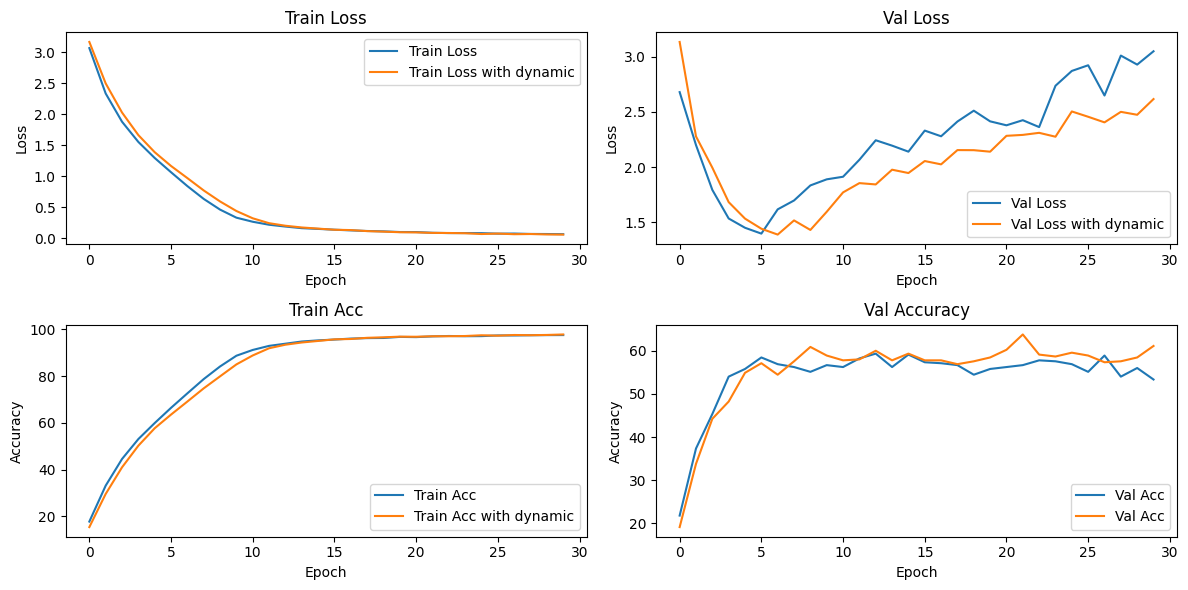

In [7]:
import matplotlib.pyplot as plt

# 讀取txt文件並提取數據
def read_data(file_path):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        i = 0
        while i < len(lines):
                if 0 < i < 31:
                    train_losses.append(float(lines[i].strip()))
                    i += 1

                elif 31 < i < 62:
                    train_accuracies.append(float(lines[i].strip()))
                    i += 1
                    
                elif 62 < i < 93:
                    val_losses.append(float(lines[i].strip()))
                    i += 1
                    
                elif 93 < i < 124:
                    val_accuracies.append(float(lines[i].strip()))
                    i += 1
                else:
                    i += 1
    return train_losses, train_accuracies, val_losses, val_accuracies

# 讀取訓練和驗證數據
train_losses, train_accuracies, val_losses, val_accuracies = read_data('resnet18.txt')
train_losses_dy, train_accuracies_dy, val_losses_dy, val_accuracies_dy = read_data('dy_resnet18.txt')
print(train_losses)
x = []
for i in range(30):
    x.append(i)

# 繪製訓練和驗證損失
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(x, train_losses, label='Train Loss')
plt.plot(x, train_losses_dy, label='Train Loss with dynamic')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()

# 繪製訓練和驗證準確度
plt.subplot(2, 2, 2)
plt.plot(x, val_losses, label='Val Loss')
plt.plot(x, val_losses_dy, label='Val Loss with dynamic')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(train_accuracies_dy, label='Train Acc with dynamic')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Acc')
plt.legend()

# 繪製訓練和驗證準確度
plt.subplot(2, 2, 4)
plt.plot(val_accuracies, label='Val Acc')
plt.plot(val_accuracies_dy, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Val Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 計算params, Macs

In [12]:
from ptflops import get_model_complexity_info
from dy_resnet import resnet18
import timm

model1 = resnet18()
macs, params = get_model_complexity_info(model1, (3, 224, 224), as_strings=True,
                                         print_per_layer_stat=False, verbose=True)
print('for dynamic conv resnet18 :')
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

model2 = timm.create_model('resnet18', pretrained=False, num_classes=50)
macs, params = get_model_complexity_info(model2, (3, 224, 224), as_strings=True,
                                         print_per_layer_stat=False, verbose=True)
print('for original resnet18 :')
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

for dynamic conv resnet18 :
Computational complexity:       178.29 MMac
Number of parameters:           44.99 M 
for original resnet18 :
Computational complexity:       1.82 GMac
Number of parameters:           11.2 M  
